In [47]:
import scipy.io
mat = scipy.io.loadmat('DATA\DREGON_free-flight_speech-high_room1_audiots.mat')

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [49]:
def f(x):
    return 3*x-1

x = np.arange(-2,2,0.1)
print(x)
y = np.array([f(_) for _ in x])
print(y)

[-2.00000000e+00 -1.90000000e+00 -1.80000000e+00 -1.70000000e+00
 -1.60000000e+00 -1.50000000e+00 -1.40000000e+00 -1.30000000e+00
 -1.20000000e+00 -1.10000000e+00 -1.00000000e+00 -9.00000000e-01
 -8.00000000e-01 -7.00000000e-01 -6.00000000e-01 -5.00000000e-01
 -4.00000000e-01 -3.00000000e-01 -2.00000000e-01 -1.00000000e-01
  1.77635684e-15  1.00000000e-01  2.00000000e-01  3.00000000e-01
  4.00000000e-01  5.00000000e-01  6.00000000e-01  7.00000000e-01
  8.00000000e-01  9.00000000e-01  1.00000000e+00  1.10000000e+00
  1.20000000e+00  1.30000000e+00  1.40000000e+00  1.50000000e+00
  1.60000000e+00  1.70000000e+00  1.80000000e+00  1.90000000e+00]
[-7.  -6.7 -6.4 -6.1 -5.8 -5.5 -5.2 -4.9 -4.6 -4.3 -4.  -3.7 -3.4 -3.1
 -2.8 -2.5 -2.2 -1.9 -1.6 -1.3 -1.  -0.7 -0.4 -0.1  0.2  0.5  0.8  1.1
  1.4  1.7  2.   2.3  2.6  2.9  3.2  3.5  3.8  4.1  4.4  4.7]


In [50]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1, input_shape=(1,))
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=0.1))

In [52]:
model.fit(x,y,epochs=300)

Epoch 1/300
2/2 [==============================] - 1s 4ms/step - loss: 31.1677
Epoch 2/300
2/2 [==============================] - 0s 5ms/step - loss: 28.2635
Epoch 3/300
2/2 [==============================] - 0s 5ms/step - loss: 25.6053
Epoch 4/300
2/2 [==============================] - 0s 7ms/step - loss: 23.0574
Epoch 5/300
2/2 [==============================] - 0s 4ms/step - loss: 20.7168
Epoch 6/300
2/2 [==============================] - 0s 4ms/step - loss: 18.6431
Epoch 7/300
2/2 [==============================] - 0s 6ms/step - loss: 16.5838
Epoch 8/300
2/2 [==============================] - 0s 5ms/step - loss: 14.8646
Epoch 9/300
2/2 [==============================] - 0s 4ms/step - loss: 13.2368
Epoch 10/300
2/2 [==============================] - 0s 6ms/step - loss: 11.7007
Epoch 11/300
2/2 [==============================] - 0s 3ms/step - loss: 10.4491
Epoch 12/300
2/2 [==============================] - 0s 7ms/step - loss: 9.1760
Epoch 13/300
2/2 [==============================] 

7/7 [==============================] - 0s 2ms/step
6.103515625e-05


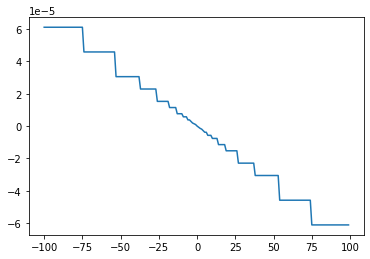

In [53]:
xtest=np.arange(-100,100,1)
preds=model.predict(xtest)
preds=preds[:,0]
ytest = np.array([f(_) for _ in xtest])
error=ytest-preds
print(np.max(error))

plt.plot(xtest,error)

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0
